In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, classification_report
import pickle

In [6]:

water_leak = pd.read_csv("/home/fahim/FELIX/leakage-training/water-leak-dataset.csv")
water_leak.tail(10)

,Timestamp,Sensor_ID,Pressure (bar),Flow Rate (L/s),Temperature (°C),Leak Status,Burst Status
990,2024-01-04 10:30:00,S009,2.592644,160.152505,17.826001,0,0
991,2024-01-04 10:35:00,S010,1.916705,71.692530,15.133383,1,0
992,2024-01-04 10:40:00,S003,3.731274,92.221595,11.051030,0,0
993,2024-01-04 10:45:00,S002,2.865562,95.884222,17.247020,0,0
994,2024-01-04 10:50:00,S008,2.760946,104.182409,19.559532,0,0
995,2024-01-04 10:55:00,S007,2.949811,55.160481,19.523946,0,0
996,2024-01-04 11:00:00,S010,3.836533,172.041322,20.724292,0,0
997,2024-01-04 11:05:00,S002,2.716468,64.033911,10.250073,0,0
998,2024-01-04 11:10:00,S002,3.017897,75.913513,19.329712,0,0
999,2024-01-04 11:15:00,S003,3.777372,179.568443,16.101606,0,0


In [7]:
water_leak.columns

Index(['Timestamp', 'Sensor_ID', 'Pressure (bar)', 'Flow Rate (L/s)',
       'Temperature (°C)', 'Leak Status', 'Burst Status'],
      dtype='object')

In [8]:
water_leak.size

7000

In [9]:
water_leak.dtypes

Timestamp            object
Sensor_ID            object
Pressure (bar)      float64
Flow Rate (L/s)     float64
Temperature (°C)    float64
Leak Status           int64
Burst Status          int64
dtype: object

In [10]:
water_leak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Timestamp         1000 non-null   object 
 1   Sensor_ID         1000 non-null   object 
 2   Pressure (bar)    1000 non-null   float64
 3   Flow Rate (L/s)   1000 non-null   float64
 4   Temperature (°C)  1000 non-null   float64
 5   Leak Status       1000 non-null   int64  
 6   Burst Status      1000 non-null   int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 54.8+ KB


In [11]:
water_leak.isnull().sum()

Timestamp           0
Sensor_ID           0
Pressure (bar)      0
Flow Rate (L/s)     0
Temperature (°C)    0
Leak Status         0
Burst Status        0
dtype: int64

In [12]:
water_leak.describe()

,Pressure (bar),Flow Rate (L/s),Temperature (°C),Leak Status,Burst Status
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3.220696,125.038082,17.434794,0.019000,0.010000
std,0.488997,44.121419,4.288908,0.136593,0.099549
min,0.910977,50.654490,10.002020,0.000000,0.000000
25%,2.859332,87.946866,13.715323,0.000000,0.000000
50%,3.265711,124.106896,17.330067,0.000000,0.000000
75%,3.607196,162.086708,20.922839,0.000000,0.000000
max,3.995364,331.754081,24.966107,1.000000,1.000000


In [13]:
duplicates = water_leak.duplicated().sum()
print(f"Total duplicate rows: {duplicates}")

Total duplicate rows: 0


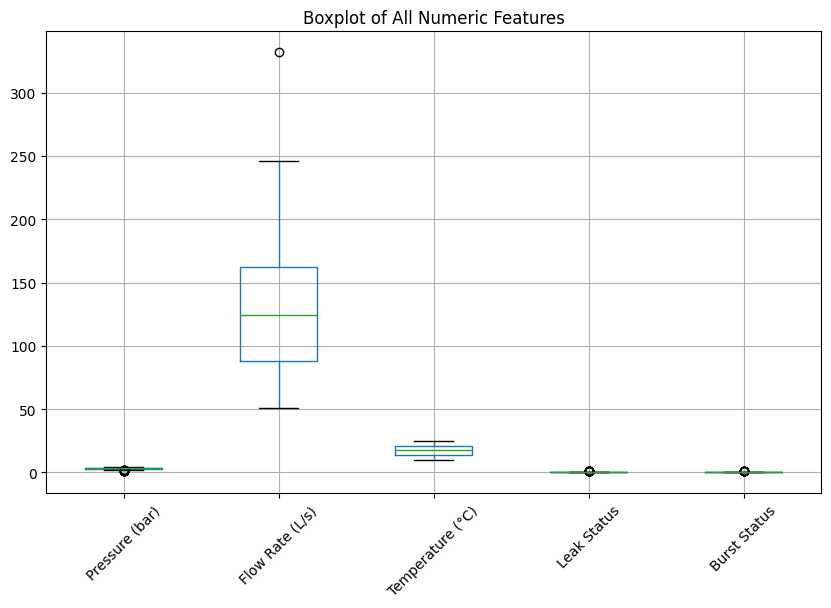

In [14]:
plt.figure(figsize=(10, 6))
water_leak.boxplot()
plt.xticks(rotation=45)  
plt.title('Boxplot of All Numeric Features')
plt.show()


New dataset shape after removing outliers: (971, 7)


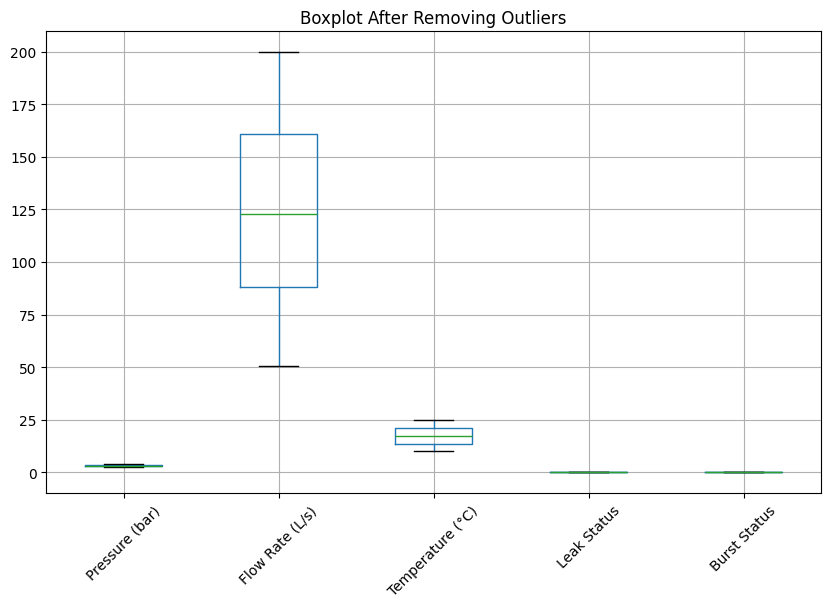

In [15]:


def remove_outliers(df):
    numeric_columns = df.select_dtypes(include=['number']).columns  
    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

water_cleaned = remove_outliers(water_leak)

print("New dataset shape after removing outliers:", water_cleaned.shape)

plt.figure(figsize=(10, 6))
water_cleaned.boxplot()
plt.xticks(rotation=45) 
plt.title('Boxplot After Removing Outliers')
plt.show()


/tmp/ipykernel_6420/1817012403.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=water_leak,x="Leak Status", palette='pastel')


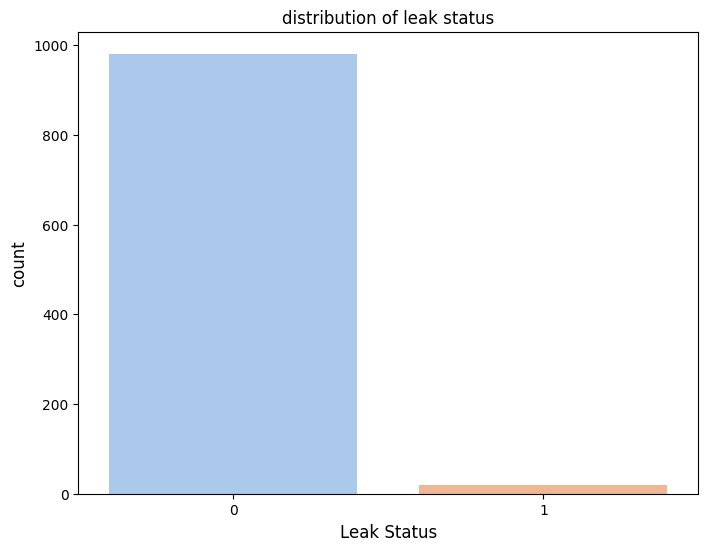

In [16]:
plt.figure(figsize=(8,6))
sns.countplot(data=water_leak,x="Leak Status", palette='pastel')
plt.title('distribution of leak status')
plt.xlabel('Leak Status', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.show()

In [17]:

leak_status_no = water_leak[water_leak['Leak Status']==0]
leak_status_yes = water_leak[water_leak['Leak Status']==1]

leak_status_yes_upsampled = resample(leak_status_yes, replace=True, n_samples=len(leak_status_no), random_state=42)

water = pd.concat([leak_status_no, leak_status_yes_upsampled])
"C:/Users/Raspberry_Pi/Desktop/smart_water_leakage_detection/water_leak_detection_1000_rows.csv"
print(water['Leak Status'].value_counts())

Leak Status
0    981
1    981
Name: count, dtype: int64


In [36]:
water.head()

,Timestamp,Sensor_ID,Pressure (bar),Flow Rate (L/s),Temperature (°C),Leak Status,Burst Status
0,2024-01-01 00:00:00,S007,3.694814,77.515218,21.695365,0,0
1,2024-01-01 00:05:00,S007,2.587125,179.926422,19.016725,0,0
3,2024-01-01 00:15:00,S009,2.936844,141.777934,12.092408,0,0
4,2024-01-01 00:20:00,S003,3.073693,197.484633,17.001443,0,0
5,2024-01-01 00:25:00,S009,2.597577,192.332831,24.484480,0,0


/tmp/ipykernel_6420/3932775468.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=water,x="Leak Status", palette='pastel')


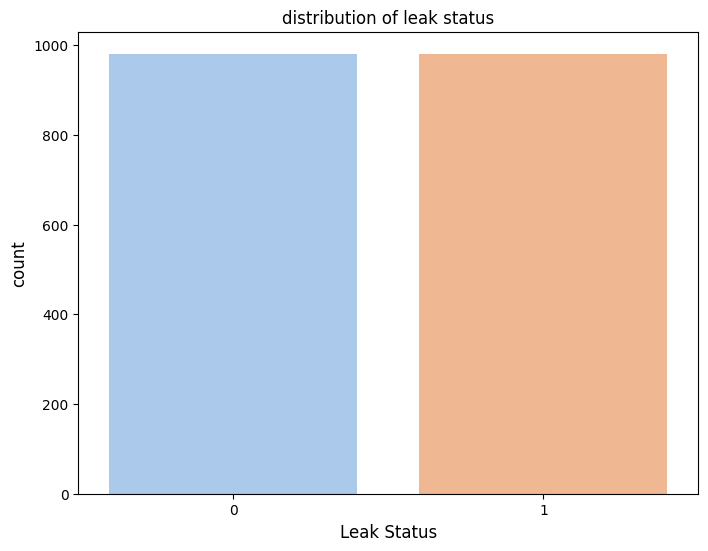

In [19]:
plt.figure(figsize=(8,6))
sns.countplot(data=water,x="Leak Status", palette='pastel')
plt.title('distribution of leak status')
plt.xlabel('Leak Status', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.show()

In [20]:
shuffled_data = shuffle(water, random_state=42)
shuffled_data.head()

,Timestamp,Sensor_ID,Pressure (bar),Flow Rate (L/s),Temperature (°C),Leak Status,Burst Status
578,2024-01-03 00:10:00,S001,2.437830,75.791466,11.423769,1,0
585,2024-01-03 00:45:00,S005,3.449609,120.392784,16.645890,0,0
461,2024-01-02 14:25:00,S010,2.834895,146.278994,18.559744,0,0
389,2024-01-02 08:25:00,S006,2.568473,71.003615,14.152215,0,0
578,2024-01-03 00:10:00,S001,2.437830,75.791466,11.423769,1,0


In [21]:
cat = shuffled_data.select_dtypes(include=['object']).columns
label_encoders = {}  

for col in cat:
    le = LabelEncoder()
    shuffled_data[col] = le.fit_transform(shuffled_data[col])
    label_encoders[col] = le 
shuffled_data.head()

,Timestamp,Sensor_ID,Pressure (bar),Flow Rate (L/s),Temperature (°C),Leak Status,Burst Status
578,578,0,2.437830,75.791466,11.423769,1,0
585,585,4,3.449609,120.392784,16.645890,0,0
461,461,9,2.834895,146.278994,18.559744,0,0
389,389,5,2.568473,71.003615,14.152215,0,0
578,578,0,2.437830,75.791466,11.423769,1,0


                  Timestamp  Sensor_ID  Pressure (bar)  Flow Rate (L/s)  \
Timestamp          1.000000   0.072340       -0.078764        -0.124176   
Sensor_ID          0.072340   1.000000       -0.173636         0.005039   
Pressure (bar)    -0.078764  -0.173636        1.000000        -0.337856   
Flow Rate (L/s)   -0.124176   0.005039       -0.337856         1.000000   
Temperature (°C)   0.089363   0.026249       -0.000932        -0.148842   
Leak Status       -0.047657   0.170252       -0.759628         0.216551   
Burst Status       0.025747  -0.023072       -0.141267         0.042043   

                  Temperature (°C)  Leak Status  Burst Status  
Timestamp                 0.089363    -0.047657      0.025747  
Sensor_ID                 0.026249     0.170252     -0.023072  
Pressure (bar)           -0.000932    -0.759628     -0.141267  
Flow Rate (L/s)          -0.148842     0.216551      0.042043  
Temperature (°C)          1.000000     0.043014      0.016075  
Leak Status    

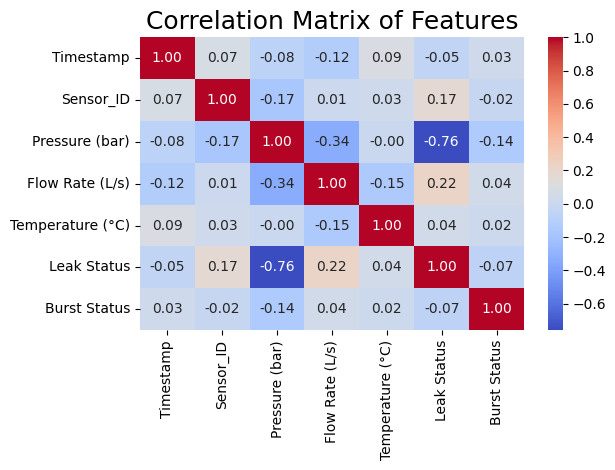

In [22]:
correlation = shuffled_data.corr()
print(correlation)

sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Correlation Matrix of Features', fontsize=18)
plt.tight_layout()
plt.show()

In [23]:
X = shuffled_data.drop(columns=["Leak Status", "Burst Status"]) 
Y = shuffled_data["Leak Status"] 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


print("Training set size:", X_train.shape, Y_train.shape)
print("Testing set size:", X_test.shape, Y_test.shape)


Training set size: (1569, 5) (1569,)
Testing set size: (393, 5) (393,)


In [24]:
X_train

,Timestamp,Sensor_ID,Pressure (bar),Flow Rate (L/s),Temperature (°C)
298,298,9,2.784542,142.842229,14.852506
2,2,1,2.448965,210.130823,10.011681
2,2,1,2.448965,210.130823,10.011681
551,551,7,3.424451,133.531766,16.236627
416,416,4,3.750475,116.066203,14.534999
...,...,...,...,...,...
720,720,5,2.807886,71.443642,23.616031
794,794,8,2.310686,143.518486,21.895945
414,414,9,1.612130,147.909747,16.661916
839,839,4,3.808939,63.066393,17.310767


In [25]:
#normalization
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


In [26]:
X_train_scaled

array([[2.98298298e-01, 1.00000000e+00, 6.07497987e-01, 3.27954012e-01,
        3.24105378e-01],
       [2.00200200e-03, 1.11111111e-01, 4.98687962e-01, 5.67330363e-01,
        5.91814997e-04],
       [2.00200200e-03, 1.11111111e-01, 4.98687962e-01, 5.67330363e-01,
        5.91814997e-04],
       ...,
       [4.14414414e-01, 1.00000000e+00, 2.27346846e-01, 3.45981495e-01,
        4.45028706e-01],
       [8.39839840e-01, 4.44444444e-01, 9.39655534e-01, 4.41548241e-02,
        4.88391583e-01],
       [7.50750751e-02, 8.88888889e-01, 9.14964531e-01, 3.74535742e-01,
        8.13595423e-02]], shape=(1569, 5))

In [27]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, Y_train)

RandomForestClassifier(random_state=42)

In [28]:
y_pred = model.predict(X_test_scaled)
y_pred

array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,

In [29]:
accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 99.75%


In [30]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       197
           1       0.99      1.00      1.00       196

    accuracy                           1.00       393
   macro avg       1.00      1.00      1.00       393
weighted avg       1.00      1.00      1.00       393



Feature: Timestamp, Importance: 0.0382
Feature: Sensor_ID, Importance: 0.0580
Feature: Pressure (bar), Importance: 0.6347
Feature: Flow Rate (L/s), Importance: 0.1547
Feature: Temperature (°C), Importance: 0.1144


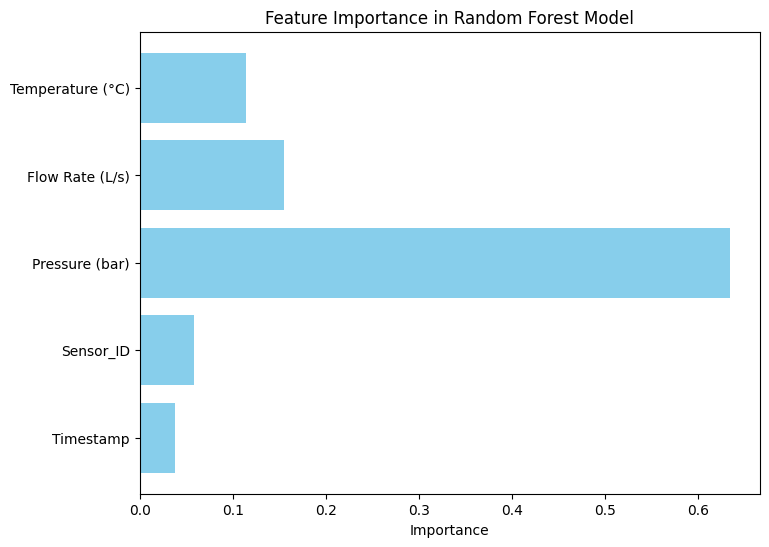

In [31]:

feature_importances = model.feature_importances_

for feature, importance in zip(X.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")
    
plt.figure(figsize=(8, 6))
plt.barh(X.columns, feature_importances, color="skyblue")
plt.xlabel("Importance")
plt.title("Feature Importance in Random Forest Model")
plt.show()

In [32]:
with open("water_leak_detection_model.pkl", "wb") as file:
    pickle.dump(model, file)

print("Model saved successfully!")

Model saved successfully!


In [33]:
test_data = {
    "Timestamp": ["2024-01-04 10:35:00"],  
    "Sensor_ID": ["S010"],  
    "Pressure(bar)": [1.916705], 
    "Flow Rate": [71.692530],  
    "Temperature": [15.133383],    
}

test_df = pd.DataFrame(test_data)
cat_columns = test_df.select_dtypes(include=['object']).columns
test_df["Timestamp"] = pd.to_datetime(test_df["Timestamp"]).astype(int) / 10**9

label_encoders = {}
for col in cat_columns:
    le = LabelEncoder()
    test_df[col] = le.fit_transform(test_df[col])
    label_encoders[col] = le  

scaler = MinMaxScaler()
x_test_data = scaler.fit_transform(test_df)

print(x_test_data)

[[0. 0. 0. 0. 0.]]


In [34]:
import pickle
with open("water_leak_detection_model.pkl", "rb") as file:
    loaded_model = pickle.load(file)

y_pred = loaded_model.predict(x_test_data)
print("Predicted Leak Status:", y_pred[0])

Predicted Leak Status: 0


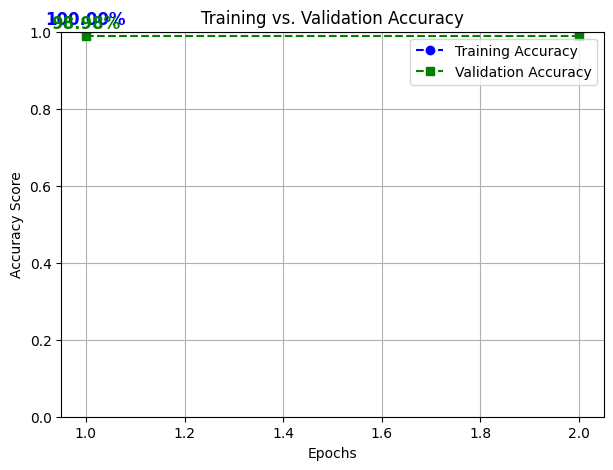

Training Accuracy: 1.0000
Validation Accuracy: 0.9898


In [35]:
X = shuffled_data.drop(columns=["Leak Status", "Burst Status"]) 
Y = shuffled_data["Leak Status"]

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)  
X_valid, X_test, Y_valid, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)  

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, Y_train)

y_train_pred = model.predict(X_train_scaled)
y_valid_pred = model.predict(X_valid_scaled)

train_accuracy = accuracy_score(Y_train, y_train_pred)
valid_accuracy = accuracy_score(Y_valid, y_valid_pred)

epochs = np.arange(1, 3) 
train_acc_values = [train_accuracy, train_accuracy] 
valid_acc_values = [valid_accuracy, valid_accuracy]  

plt.figure(figsize=(7, 5))  
plt.plot(epochs, train_acc_values, 'b--o', label="Training Accuracy") 
plt.plot(epochs, valid_acc_values, 'g--s', label="Validation Accuracy") 
plt.ylim(0, 1)  
plt.xlabel("Epochs")
plt.ylabel("Accuracy Score")
plt.title("Training vs. Validation Accuracy")
plt.legend()
plt.grid(True)
plt.text(1, train_accuracy + 0.02, f"{train_accuracy:.2%}", ha='center', fontsize=12, fontweight='bold', color='blue')
plt.text(1, valid_accuracy + 0.02, f"{valid_accuracy:.2%}", ha='center', fontsize=12, fontweight='bold', color='green')
plt.show() 

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {valid_accuracy:.4f}")
